# Unsupervides Learning: Clustering Banks
### Clustering analysis to identify groups of banks with different susceptibility to macroeconomic shifts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA
from scipy.stats import median_abs_deviation

In [2]:
# Custom functions
from sample_panel.merge_datasets import merge_bank_macro_datasets
from supervised_learning.time_series import create_bank_train_set
from statsmodels.tsa.ar_model import AutoReg

## Loading data

In [3]:
# Load bank panel data
bank_data = pd.read_csv('df_response_vars.csv')

In [4]:
# Load macroeconomic data
macro_data = pd.read_csv('macro_features.csv')
macro_columns = macro_data.columns

# Factors with lags are not used in the model. Remove factors with lags
new_macro_columns = [col for col in macro_columns if '_lag' not in col]
macro_data = macro_data[new_macro_columns]

In [5]:
# Load PCA components
pca_data = pd.read_csv('macro_pca_df.csv')

In [6]:
# Load additional macro variables
macro_data1 = pd.read_csv('macro_most_inf_df.csv')
# Clean column names
macro_data1.columns = [col.replace('\n', ' ') for col in macro_data1.columns]

In [7]:
# Merge the bank panel and macroeconomic indicators
data_set = merge_bank_macro_datasets(bank_data, macro_data, pca_data, macro_data1)

## Parameters

In [8]:
# Response variable
y_col = 'Provision for Loan Lease Losses as % of Aver. Assets'

In [9]:
# Macroeconomic factors chosen in the prior steps
selected_factors = {
    'Real GDP growth_ema3': [-1, 0, 1],
    'BBB corporate yield': [1, 1, 1], 
    '3-month Treasury rate change': [-1, 2, 1], 
    'Dow Jones Total Stock Market Index change': [-1, 3, 1], 
    'Market Volatility Index': [1, 4, 1], 
    'Market Volatility Index change': [1, 4, 1],    
}

factors_df = pd.DataFrame.from_dict(selected_factors, orient='index', columns=['sign', 'group', 'calc_ema'])

## Sample of banks

In [10]:
banks = data_set['IDRSSD'].unique()

In [11]:
len(banks)

286

#### Exclude banks with zero variance of the response variable

In [12]:
response_variance = data_set.groupby('IDRSSD')[[y_col]].std()
banks_exclude = response_variance.index[response_variance[y_col]==0]
banks_exclude = list(banks_exclude)
banks_exclude

[911807, 5278251]

In [13]:
banks_upd = [bank for bank in list(banks) if bank not in banks_exclude]

In [14]:
len(banks_upd)

284

#### Sample size for each bank

In [15]:
data_set_banks = data_set[data_set['IDRSSD'].isin(banks_upd)].copy()

In [16]:
sample_size = data_set_banks.groupby('IDRSSD')['Financial Institution Name'].count()

In [17]:
# Exclude banks with sample size < 20
banks_exclude = sample_size[sample_size<20].index

In [18]:
banks_upd = [bank for bank in list(banks_upd) if bank not in banks_exclude]

In [19]:
len(banks_upd)

242

In [20]:
train_up_to = '2021-12-31'

## Features for clustering

The features used for clustering are defined for each bank as correlation coefficients between the residuals of the AR(1) model fitted for this bank and the selected macroeconomic indicators.

In [21]:
# Dataframe for the result
corr_df = pd.DataFrame(index=banks_upd, columns=factors_df.index)

In [22]:
autocor_order=1

for bank_id in banks_upd:
    
    # Sample for the bank
    _, bank_data_train = create_bank_train_set(bank_id, data_set, 
                                               y_col, factors_df,
                                               train_up_to)
    
    # Fit autocorrelation model for the bank
    AR_model = AutoReg(bank_data_train[y_col], lags=autocor_order).fit()
    bank_data_train = bank_data_train.copy()
    # Residuals of the AR(1) model
    bank_data_train['residuals'] = AR_model.resid
    bank_data_train_wt_nans = bank_data_train.dropna()
    
    # For each selected macroeconomic indicator estimate correlation with the residuals
    for macro_ind in factors_df.index:
        corr_df.loc[bank_id, macro_ind] = np.corrcoef(bank_data_train_wt_nans['residuals'],
                                                      bank_data_train_wt_nans[macro_ind])[0, 1]   

In [23]:
corr_df.head(5)

,Real GDP growth_ema3,BBB corporate yield,3-month Treasury rate change,Dow Jones Total Stock Market Index change,Market Volatility Index,Market Volatility Index change
12311,-0.311547,0.32187,-0.232761,-0.513856,0.390529,0.336971
17147,-0.34234,0.384283,-0.235813,-0.518726,0.31702,0.267081
23504,-0.308534,0.172094,-0.276053,-0.144633,0.346868,0.097387
30810,-0.363848,0.317677,-0.21618,-0.36588,0.358983,0.314684
34537,-0.177044,0.251868,-0.320934,-0.421803,0.227636,0.173477


## Identifying bank clusters

In [24]:
# Define possible number of clusters
k_vals = range(2, 10)
# Result of clustering
k_means_res = []
# Criteria to choose the optimal number of clusters
score_d_b = []
score_c_h = []


for k in k_vals:
    
    k_means_banks = KMeans(n_clusters=k, random_state = 42).fit(corr_df)
    k_means_res.append(k_means_banks)
    
    # Criteria to choose the optimal number of clusters
    score_d_b.append(davies_bouldin_score(corr_df, k_means_banks.labels_))
    score_c_h.append(calinski_harabasz_score(corr_df, k_means_banks.labels_))

### Finding the optimal number of clusters

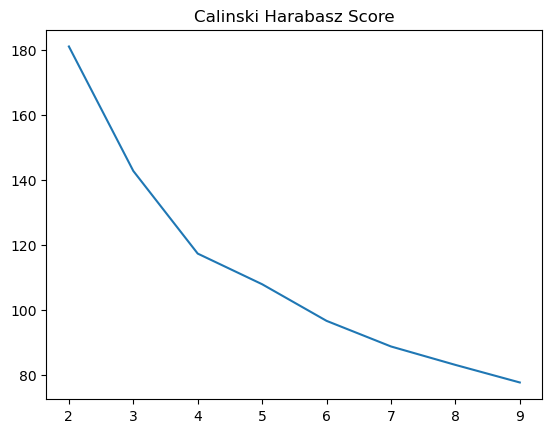

In [25]:
sns.lineplot(x = k_vals, y = score_c_h)
plt.title('Calinski Harabasz Score');

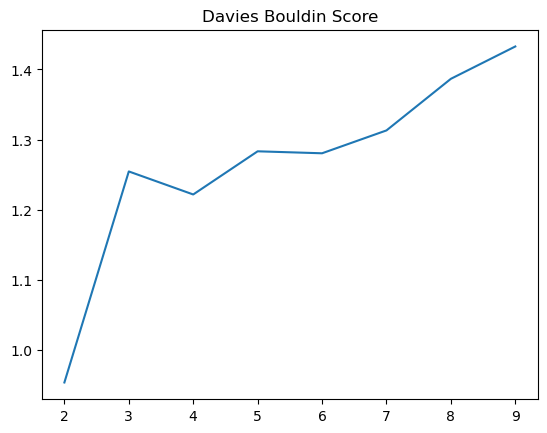

In [26]:
sns.lineplot(x = k_vals, y = score_d_b)
plt.title('Davies Bouldin Score');

### Results of clustering for chosen k=2

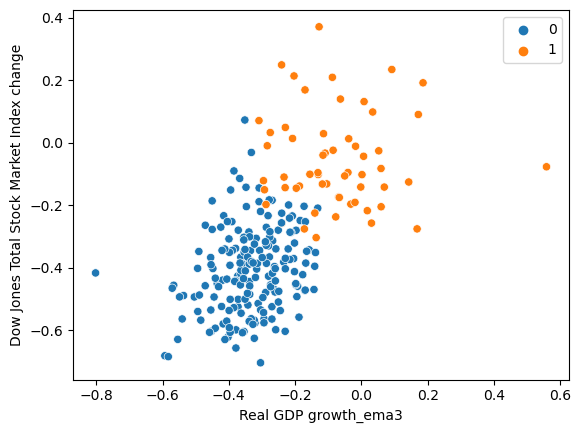

In [27]:
sns.scatterplot(data = corr_df, 
                x = 'Real GDP growth_ema3', 
                y = 'Dow Jones Total Stock Market Index change',
                hue = k_means_res[0].labels_);

In [28]:
# Apply PCA to reduce dimensions from 6 to 2
pca = PCA(n_components=2)
pca.fit(corr_df)
pca.explained_variance_ratio_

array([0.65773334, 0.12922929])

In [29]:
corr_df_pca = pca.transform(corr_df)

In [30]:
corr_df_pca = pd.DataFrame(corr_df_pca)
corr_df_pca.rename(columns={0: 'PCA1', 1: 'PCA2'}, inplace=True)
corr_df_pca.head(5)

,PCA1,PCA2
0,-0.231660,0.005725
1,-0.207023,-0.098822
2,0.123780,-0.097469
3,-0.144283,-0.038316
4,0.000195,-0.099327


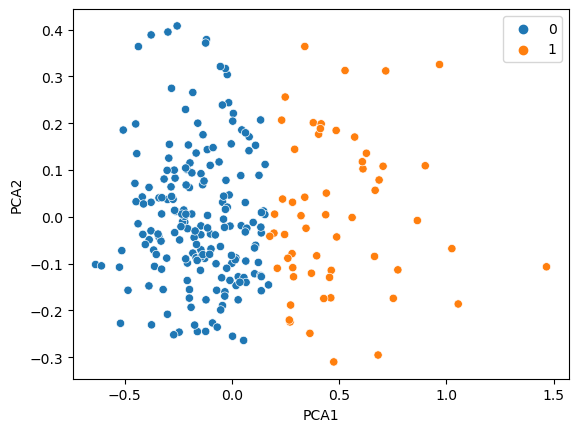

In [31]:
sns.scatterplot(data = corr_df_pca, 
                x = 'PCA1', 
                y = 'PCA2',
                hue = k_means_res[0].labels_);